# Walkthrough Challenge 2 - Generate images with DALL-E 3 and interact with images with GPT-4 Vision

Duration: 45 minutes

## Overview
- In this challenge, you will learn how to generate images with DALL-E 3, a generative model that generates images from text descriptions. We will also combine this model with embedding and text generation models.
- You will also learn how to chat with images with GPT-4 Vision, a large multimodal model that can analyze images and provide textual responses to questions about the them.

## Prerequisites

- Please ensure that you have completed the [Setup](../setup/setup.ipynb) before starting this challenge.

### Task 1: Configure and Initialize Semantic Kernel

⚠️ Note: You should have already completed all tasks on the [Setup](../setup/setup.ipynb). If you have not, please go back and complete it now.

#### Step 1: Load Semantic Kernel settings

In this step, we will load the Semantic Kernel settings that we created in the [Setup](../setup/setup.ipynb) notebook.

In [63]:
#r "nuget: Microsoft.SemanticKernel, 1.0.1"
#r "nuget: System.Numerics.Tensors, 8.0.0"
#r "nuget: SkiaSharp, 2.88.3"
#r "nuget: SkiaSharp.NativeAssets.Linux.NoDependencies, 2.88.3"

#!import ../setup/config/Settings.cs
#!import ../setup/config/Utils.cs
#!import ../setup/config/SkiaUtils.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.TextToImage;
using Microsoft.SemanticKernel.Embeddings;
using Microsoft.SemanticKernel.ChatCompletion;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using System.Numerics.Tensors;
using Microsoft.DotNet.Interactive;
using InteractiveKernel = Microsoft.DotNet.Interactive.Kernel;

Installed Packages Microsoft.SemanticKernel, 1.0.1 SkiaSharp, 2.88.3 SkiaSharp.NativeAssets.Linux.NoDependencies, 2.88.3 System.Numerics.Tensors, 8.0.0

#### Step 2: Initialize Semantic Kernel

This challenge uses `dall-e-3` and `gpt4-vision` models. We will initialize the Semantic Kernel with these models.

If you are using Azure OpenAI Service, make sure that you have these models deployed in your workspace. At the time of writing, these particular models are only available in a restrict number of Azure Regions. Please refer to [Azure OpenAI Service models](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models) documentation for more information.

In [3]:
using Kernel = Microsoft.SemanticKernel.Kernel;

#pragma warning disable SKEXP0001, SKEXP0002, SKEXP0011, SKEXP0012

// Load OpenAI credentials from config/settings.json
var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile("../setup/config/settings.json");

// Configure the three AI features: text embedding (using Ada), chat completion, image generation (DALL-E 3)
var builder = Kernel.CreateBuilder();

if(useAzureOpenAI)
{
    builder.AddAzureOpenAITextEmbeddingGeneration("text-embedding-ada-002", azureEndpoint, apiKey);
    builder.AddAzureOpenAIChatCompletion("gpt-4-vision", azureEndpoint, apiKey);
    builder.AddAzureOpenAITextToImage("Dalle3", azureEndpoint, apiKey);
}
else
{
    builder.AddOpenAITextEmbeddingGeneration("text-embedding-ada-002", apiKey, orgId);
    builder.AddOpenAIChatCompletion("gpt-4-vision", apiKey, orgId);
    builder.AddOpenAITextToImage(apiKey, orgId);
}

var kernel = builder.Build();

// Get AI service instance used to generate images
var dallE = kernel.GetRequiredService<ITextToImageService>();

// Get AI service instance used to extract embedding from a text
var textEmbedding = kernel.GetRequiredService<ITextEmbeddingGenerationService>();

### Task 2: Create a Image Generation Semantic Function

Let's initialize some content that will be used to create the description for the image that we want to generate. In this example, we will use an excerpt from [Wikipedia](https://en.wikipedia.org/wiki/Colossus_of_Rhodes) about the Colossus of Rhodes, one of the Seven Wonders of the Ancient World.

In [24]:
var input = """
The Colossus of Rhodes (Ancient Greek: ὁ Κολοσσὸς Ῥόδιος, romanized: ho Kolossòs Rhódios; Greek: Κολοσσός της Ρόδου, romanized: Kolossós tes Rhódou)[a] was a statue of the Greek sun god Helios, erected in the city of Rhodes, on the Greek island of the same name, by Chares of Lindos in 280 BC.
One of the Seven Wonders of the Ancient World, it was constructed to celebrate the successful defence of Rhodes city against an attack by Demetrius I of Macedon, who had besieged it for a year with a large army and navy.
According to most contemporary descriptions, the Colossus stood approximately 70 cubits, or 33 metres (108 feet) high – approximately the height of the modern Statue of Liberty from feet to crown – making it the tallest statue in the ancient world.[2] It collapsed during the earthquake of 226 BC, although parts of it were preserved.
In accordance with a certain oracle, the Rhodians did not rebuild it.[3] John Malalas wrote that Hadrian in his reign re-erected the Colossus,[4] but he was mistaken.[5] According to the Suda, the Rhodians were called Colossaeans (Κολοσσαεῖς), because they erected the statue on the island.[6]
""";

We can now create a Semantic Function that will generate a image description from the content that we have initialized.

In [70]:
string prompt = """
{{$input}}

Make a short description of the text above.
It should be a visual description of the text, that will be used to generate an image.
""";

// Create ExecutionSettings for the prompt
var executionSettings = new OpenAIPromptExecutionSettings
{
    MaxTokens = 256,
    Temperature = 1
};

// Create a semantic function that generate a random image description.
var imgDescriptionFunction = kernel.CreateFunctionFromPrompt(prompt, executionSettings);

Let's execute the Semantic Function to generate the image description. After the image description is generated, we will ask DALL-E 3 to generate an image from the description.


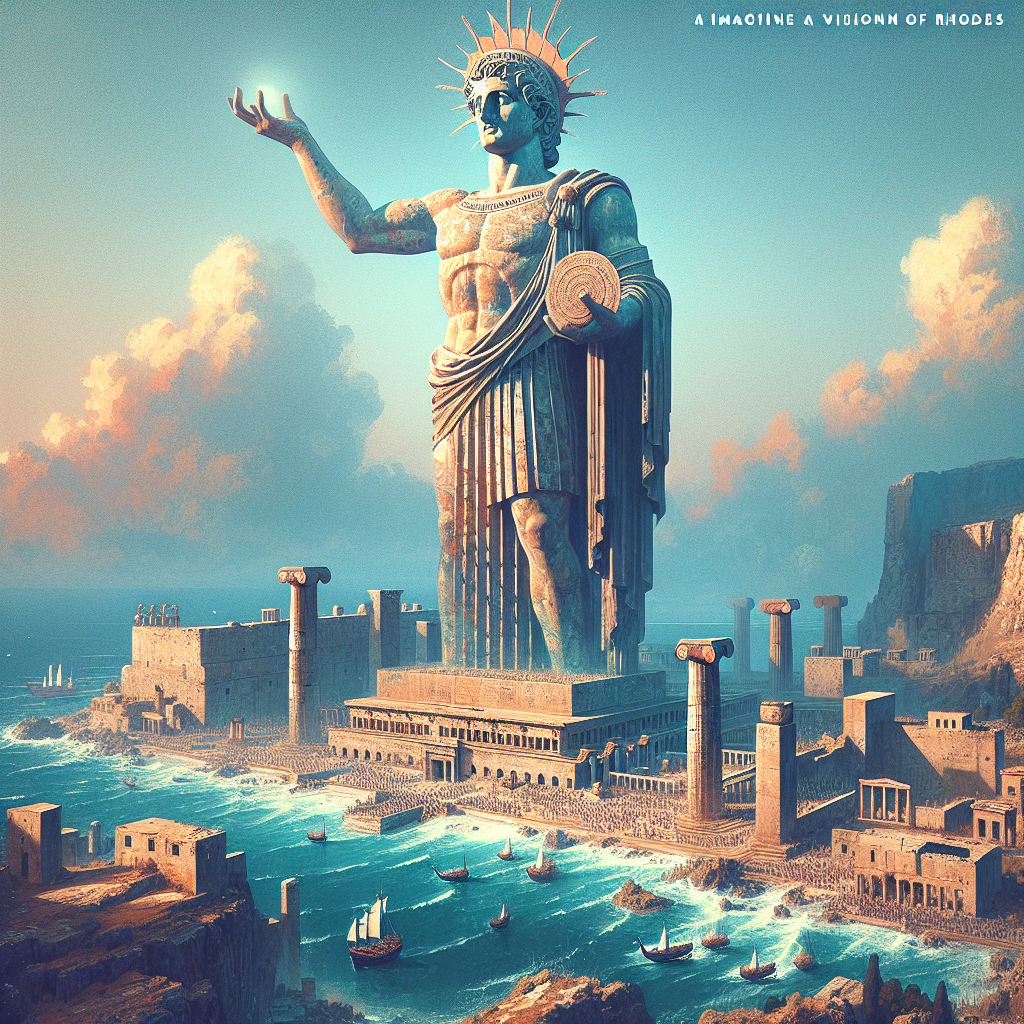

Image generated from text: The Colossus of Rhodes was a towering statue of the Greek sun god Helios, standing at 33 meters high and erected on the island of Rhodes by Chares of Lindos in 280 BC. It was created to commemorate Rhodes' victory over Demetrius I of Macedon's siege. Resembling the height of the modern Statue of Liberty, the Colossus was the tallest statue in the ancient world until it was destroyed by an earthquake in 226 BC. The ruins were not rebuilt due to a specific oracle's advice.


In [71]:
#pragma warning disable SKEXP0002

var imageDescriptionResult = await kernel.InvokeAsync(imgDescriptionFunction, new() { ["input"] = input });
var imageDescription = imageDescriptionResult.ToString();

// Use DALL-E 3 to generate an image. OpenAI in this case returns a URL (though you can ask to return a base64 image)
var imageUrl = await dallE.GenerateImageAsync(imageDescription.Trim(), 1024, 1024);

await SkiaUtils.ShowImage(imageUrl, 1024, 1024);

Console.WriteLine("Image generated from text: " + imageDescription);

You can experiment with different content and see how the generated image changes. For example, try changing the content to a description of [Machu Picchu](https://en.wikipedia.org/wiki/Machu_Picchu) in Peru, one of the New Seven Wonders of the World. Or even a biography of your favorite celebrity!


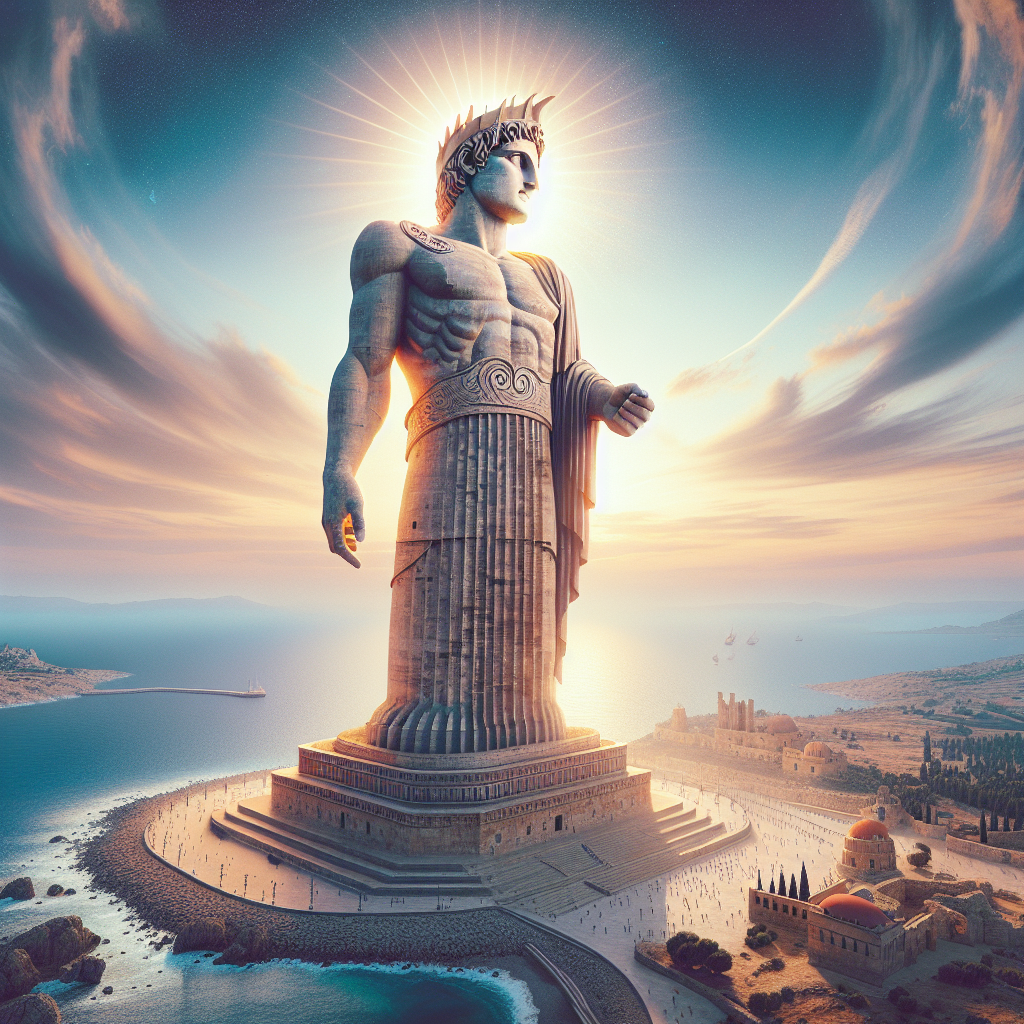

Image generated from text: The Colossus of Rhodes was a towering statue of the Greek sun god Helios, standing at 33 meters high and erected on the island of Rhodes by Chares of Lindos in 280 BC. It was created to commemorate Rhodes' victory over Demetrius I of Macedon's siege. Resembling the height of the modern Statue of Liberty, the Colossus was the tallest statue in the ancient world until it was destroyed by an earthquake in 226 BC. The ruins were not rebuilt due to a specific oracle's advice.


In [73]:
var content = """
Machu Picchu is a 15th-century Inca citadel located in the Eastern Cordillera of southern Peru on a 2,430-meter (7,970 ft) mountain ridge.[2][3] Often referred to as the "Lost City of the Incas", it is the most familiar icon of the Inca Empire. It is located in the Machupicchu District within Urubamba Province[4] above the Sacred Valley, which is 80 kilometers (50 mi) northwest of Cusco. The Urubamba River flows past it, cutting through the Cordillera and creating a canyon with a tropical mountain climate.[5] In reference to the site's name, for most English or Spanish speakers, the first 'c' in Picchu is silent. In English, the name is pronounced /ˌmɑːtʃuː ˈpiːtʃuː/ MAH-choo PEE-choo[6][7] or /ˌmætʃuː ˈpiːktʃuː/ MATCH-oo PEAK-choo,[7][8] in Spanish as [ˈmatʃu ˈpitʃu] or [ˈmatʃu ˈpiɣtʃu],[9] and in Quechua (Machu Pikchu)[10] as [ˈmatʃʊ ˈpɪktʃʊ].
""";

#pragma warning disable SKEXP0002

var imgResult = await kernel.InvokeAsync(imgDescriptionFunction, new() { ["input"] = content });
var imgDescription = imageDescriptionResult.ToString();

// Use DALL-E 3 to generate an image. OpenAI in this case returns a URL (though you can ask to return a base64 image)
var imageUrl = await dallE.GenerateImageAsync(imgDescription.Trim(), 1024, 1024);

await SkiaUtils.ShowImage(imageUrl, 1024, 1024);

Console.WriteLine("Image generated from text: " + imgDescription);

### Task 3: Use GPT-4 Vision to Interact with Images

GPT-4 Vision is a large multimodal model that can analyze images and provide textual responses to questions made about the images.

In this example, we will use GPT-4 Vision to analyze the image that we generated in the previous task.

In [66]:
var chatCompletionService = kernel.GetRequiredService<IChatCompletionService>();

var chatHistory = new ChatHistory("You are trained to interpret images and make responsible assumptions about them.");

chatHistory.AddUserMessage(new ChatMessageContentItemCollection
{
    new TextContent("Give me a description of this image:"),
    new ImageContent(new Uri(imageUrl))
});

var executionSettings = new OpenAIPromptExecutionSettings
{
    MaxTokens = 256,
    Temperature = 0.2
};

var visionReply = await chatCompletionService.GetChatMessageContentAsync(chatHistory, executionSettings);

Console.WriteLine(visionReply.Content);

The image depicts a grandiose ancient setting, reminiscent of a Greek or Roman city. In the foreground, there is a colossal statue adorned with intricate armor and a decorative helmet, seated on a throne under a monumental structure with classical columns. The statue overlooks a sprawling complex of classical architecture, featuring a series of columns, arches, and ancient buildings with a central open plaza.

In the background, the city extends towards a coastline with a calm sea. Several ships with sails are visible near the shore, suggesting a bustling port. The landscape is surrounded by mountains in the distance under a clear sky, with the sun casting a warm glow over the entire scene, creating a sense of historical grandeur and lost civilization.


As an exercise, we will use the embeddings model `text-embedding-ada-002` to measure how similar the description `gpt4-vision` generated is to the description that we used to generate the image.

Text embeddings are a way to represent text as a vector of floating-point numbers. The embeddings model `text-embedding-ada-002` is trained on a large corpus of text and can be used to measure the semantic similarity between two pieces of text.

To learn more about embeddings, you can explore the [Undestanding Embeddings](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/understand-embeddings) Microsoft Learn page.

In [72]:
var origEmbedding = await textEmbedding.GenerateEmbeddingsAsync(new List<string> { imageDescription } );
var visionEmbedding = await textEmbedding.GenerateEmbeddingsAsync(new List<string> { visionReply.Content } );
var similarity = TensorPrimitives.CosineSimilarity(origEmbedding.First().Span, visionEmbedding.First().Span);

Console.WriteLine($"GPT-4-Vision description:\n{Utils.WordWrap(visionReply.Content, 90)}\n");
Console.WriteLine($"Real description:\n{Utils.WordWrap(imageDescription.Trim(), 90)}\n");
Console.WriteLine($"Similarity: {similarity:0.00}\n\n");

GPT-4-Vision description:
The image depicts a grandiose ancient setting, reminiscent of a Greek or Roman city. In
the foreground, there is a colossal statue adorned with intricate armor and a decorative
helmet, seated on a throne under a monumental structure with classical columns. The statue
overlooks a sprawling complex of classical architecture, featuring a series of columns,
arches, and ancient buildings with a central open plaza.

In the background, the city
extends towards a coastline with a calm sea. Several ships with sails are visible near the
shore, suggesting a bustling port. The landscape is surrounded by mountains in the
distance under a clear sky, with the sun casting a warm glow over the entire scene,
creating a sense of historical grandeur and lost civilization.


Real description:
The Colossus of Rhodes was a towering statue of the Greek sun god Helios, standing at 33
meters high and erected on the island of Rhodes by Chares of Lindos in 280 BC. It was
created to comme

### Task 4: Automate Invoice Processing with GPT-4 Vision 


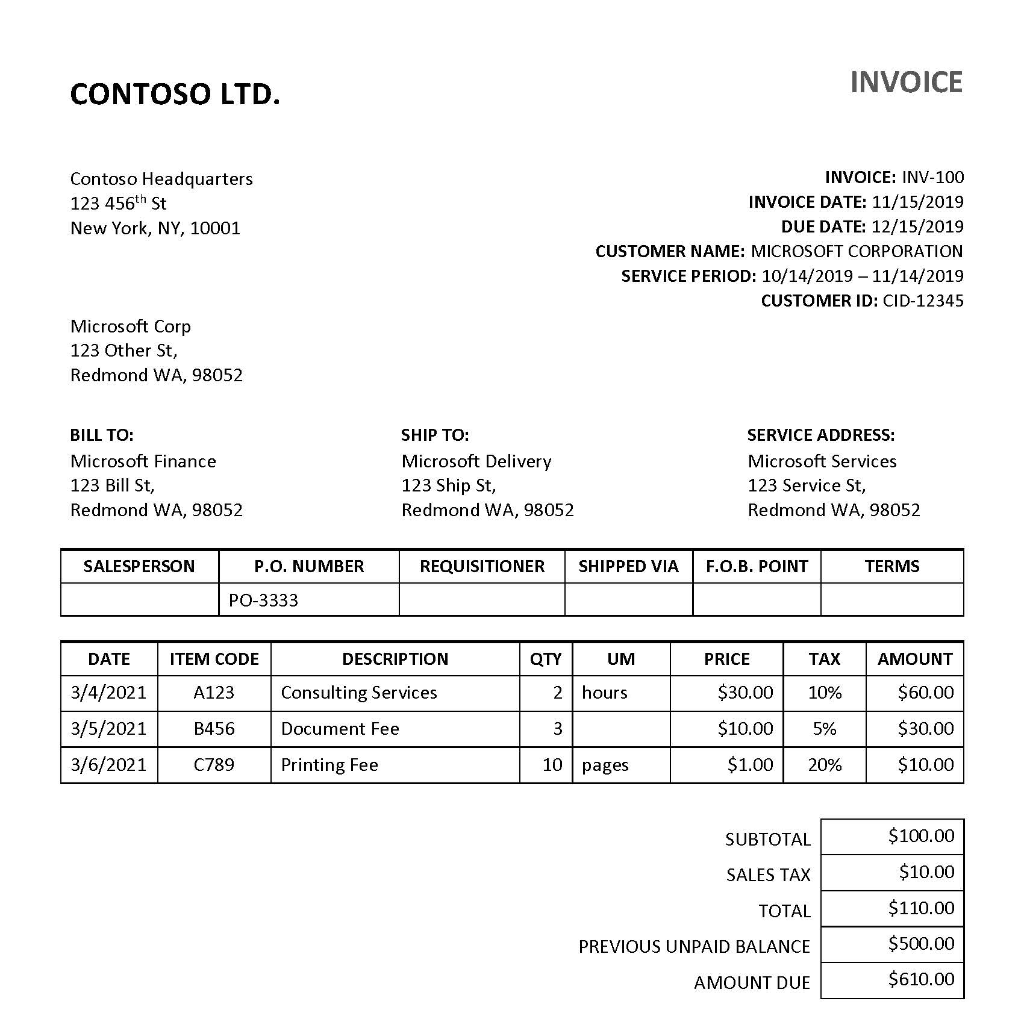

In [74]:
const string ImageUri = "https://learn.microsoft.com/pt-pt/azure/ai-services/document-intelligence/media/sample-invoice.jpg?view=doc-intel-4.0.0";

// Show the above image
await SkiaUtils.ShowImage(ImageUri, 1024, 1024);

In [86]:

var chatCompletionService = kernel.GetRequiredService<IChatCompletionService>();

var chatHistory = new ChatHistory("You are trained to interpret images about invoices and make responsible assumptions about them.");

chatHistory.AddUserMessage(new ChatMessageContentItemCollection
{
    new TextContent("Give me a json with the invoice data, namely the invoice_number, invoice_date, total_amount and due_date."),
    new ImageContent(new Uri(ImageUri))
});

var executionSettings = new OpenAIPromptExecutionSettings
{
    MaxTokens = 256,
    Temperature = 0.2
};

var reply = await chatCompletionService.GetChatMessageContentAsync(chatHistory, executionSettings);

reply.Content.DisplayAs("text/markdown");

```json
{
  "invoice_number": "INV-100",
  "invoice_date": "11/15/2019",
  "total_amount": "$610.00",
  "due_date": "12/15/2019"
}
```

You successfully completed challenge 2! 🚀🚀🚀

 **[Home](../../Readme.md)** - [Next Challenge Solution](../challenge-3/solution.ipynb)